In [1]:
import pandas as pd
df1 = pd.read_csv('mentalhealth.csv')
df1=df1.drop("Question_ID", axis=1)
df1.head()

,Questions,Answers
0,What does it mean to have a mental illness?,Mental illnesses are health conditions that di...
1,Who does mental illness affect?,"Mental illness does can affect anyone, regardl..."
2,What are some of the warning signs of mental i...,Symptoms of mental health disorders vary depen...
3,Can people with mental illness recover?,"When healing from mental illness, early identi..."
4,What should I do if I know someone who appears...,We encourage those with symptoms to talk to th...


# Dataset Loading

In [2]:
import json

with open('intents.json', 'r') as f:
    data = json.load(f)

df2 = pd.DataFrame(data['intents'])
df2=df2.drop("tag", axis=1)
df2["Questions"]=df2["patterns"]
df2["Answers"]=df2["responses"]
df2=df2.drop(["patterns", "responses"], axis=1)
df2["Questions"]=df2["Questions"].astype("str").str.replace('[','').str.replace(']','')
df2["Answers"]=df2["Answers"].astype("str").str.replace('[','').str.replace(']','')
df2.head()

,Questions,Answers
0,"'Hi', 'Hey', 'Is anyone there?', 'Hi there', '...",'Hello there. Tell me how are you feeling toda...
1,'Good morning',"""Good morning. I hope you had a good night's s..."
2,'Good afternoon','Good afternoon. How is your day going?'
3,'Good evening','Good evening. How has your day been?'
4,'Good night',"'Good night. Get some proper sleep', 'Good nig..."


# Downloading Conversational Dataset from Hugging Face

In [3]:
from datasets import load_dataset

ds = load_dataset("ShenLab/MentalChat16K")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Interview_Data_6K.csv:   0%|          | 0.00/13.6M [00:00<?, ?B/s]

Synthetic_Data_10K.csv:   0%|          | 0.00/32.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16084 [00:00<?, ? examples/s]

In [4]:
from datasets import load_dataset

# Load the dataset
ds = load_dataset("ShenLab/MentalChat16K")

# Export the 'train' split to CSV
try:
    output_file = "mentalchat16k_train.csv"
    ds["train"].to_csv(output_file, index=False)  # index=False to avoid adding row numbers
    print(f"✅ Train split saved to {output_file}")

except KeyError:
    print("❌ 'train' split not found in the dataset.")
except Exception as e:
    print(f"❌ Error while saving CSV: {e}")

Creating CSV from Arrow format:   0%|          | 0/17 [00:00<?, ?ba/s]

✅ Train split saved to mentalchat16k_train.csv


In [5]:
df3=pd.read_csv("mentalchat16k_train.csv")
df3=df3.drop("instruction", axis=1)
df3["Questions"]=df3["input"]
df3["Answers"]=df3["output"]
df3=df3.drop(["input", "output"], axis=1)
df3.head()

,Questions,Answers
0,I've been struggling with my mental health for...,I understand that you've been dealing with a s...
1,I've been feeling overwhelmed with my caregivi...,"Your situation is complex, and it's important ..."
2,I've been feeling constantly anxious and unabl...,I can see that you're dealing with a great dea...
3,"My mom has Alzheimer's, and I've been her prim...",I'm sorry to hear that your siblings' demands ...
4,"I've tried setting boundaries, but it feels li...","Your concerns are valid, and it's crucial to p..."


# Combined above three datasets into one single csv file

In [6]:
df_train= df3[:5000]
df = pd.concat([df1, df2, df_train], ignore_index=True)
df.to_csv('final_combined_subset.csv', index=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5177 entries, 0 to 5176
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Questions  5177 non-null   object
 1   Answers    5177 non-null   object
dtypes: object(2)
memory usage: 81.0+ KB


# Importing important libraries to be used throughout the notebook

In [7]:
import re
import random
import numpy as np
from tensorflow.keras.utils import plot_model
from keras.models import load_model
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

In [8]:
#Clean Answers Column
df['Answers'] = df['Answers'].astype(str)
df['Answers'] = df['Answers'].str.replace(r"[\\'\",\(\)\-/]", '', regex=True)
df['Answers'] = df['Answers'].str.replace('\n', ' ')
df['Answers'] = df['Answers'].str.replace(r'\s+', ' ', regex=True).str.strip()
# Clean Questions column
df['Questions'] = df['Questions'].astype(str).str.replace(r"[\\'\",\(\)\-/]", '', regex=True)
# Fill Null values
df['Answers'] = df['Answers'].fillna('')
df['Questions'] = df['Questions'].fillna('')

print(" Dataframe is now ready to be taken for next step of preprocessing")

 Dataframe is now ready to be taken for next step of preprocessing


# Creating Question Answer pair fromthe dataset to be used for chatbot training

In [9]:
pairs=[]

for i in range(df.shape[0]):
  pairs.append((df['Questions'][i],df['Answers'][i]))
print("Pairs creation completed successfully")

Pairs creation completed successfully


# Tokenization Process

In [10]:
input_ques = []
target_ans = []
input_tokens = set()
target_tokens = set()

for input_doc, target_doc in pairs:
    input_ques.append(input_doc)

    # Split punctuation if needed
    target_doc = " ".join(re.findall(r"[\w']+|[^\s\w]", target_doc))

    # Add start/end tokens
    target_doc = '<start> ' + target_doc + ' <end>'
    target_ans.append(target_doc)

    # Update vocab sets
    input_tokens.update(re.findall(r"[\w']+|[^\s\w]", input_doc))
    target_tokens.update(target_doc.split())

# Convert to sorted lists
input_tokens = sorted(input_tokens)
target_tokens = sorted(target_tokens)

num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)
print("Tokens generated successfully")

Tokens generated successfully


# Creating Dictionaries for mapping-
# i)words/Tokens -> IDs
# ii) reverse mappring - IDs -> Tokens/Words

In [11]:
input_features_dict = {token: i for i, token in enumerate(input_tokens)}
target_features_dict = {token: i for i, token in enumerate(target_tokens)}

reverse_input_features_dict = {i: token for token, i in input_features_dict.items()}
reverse_target_features_dict = {i: token for token, i in target_features_dict.items()}

print("Dictionaries of input_output features and reverse input-output features created succeesfully")

Dictionaries of input_output features and reverse input-output features created succeesfully


# Extracting the longest sentence in user input and bot response

In [12]:
max_encoder_seq_length = 0
for input_doc in input_ques:
    length = len(re.findall(r"[\w']+|[^\s\w]", input_doc))
    if length > max_encoder_seq_length:
        max_encoder_seq_length = length

# Finding the longest sentence in bot response in decoder
max_decoder_seq_length = 0
for target_doc in target_ans:
    length = len(re.findall(r"[\w']+|[^\s\w]", target_doc))
    if length > max_decoder_seq_length:
        max_decoder_seq_length = length

print("Length of longest sentence in user input=", max_encoder_seq_length)
print("Length of longest sentence in bot response=", max_decoder_seq_length)

Length of longest sentence in user input= 341
Length of longest sentence in bot response= 1961


# Restricting the maximum sentence length to be used for encoder and decoder models to be alength of 95 percentile to the longest sentence detected in input answer and target answer , respectively

In [13]:
# 1. Calculate the lengths of all input questions in input_ques
input_lengths = [len(re.findall(r"[\w']+|[^\s\w]", doc)) for doc in input_ques]

# 2. Calculate the lengths of all target answers in target_ans
target_lengths = [len(doc.split()) for doc in target_ans]

# 3. Determine the 95th percentile of input_lengths
max_encoder_seq_length1 = int(np.percentile(input_lengths, 95))

# 4. Determine the 95th percentile of target_lengths
max_decoder_seq_length1 = int(np.percentile(target_lengths, 95))

# 5. Print the calculated max_encoder_seq_length1 and max_decoder_seq_length1
print("95th percentile for encoder sequence length:", max_encoder_seq_length1)
print("95th percentile for decoder sequence length:", max_decoder_seq_length1)

95th percentile for encoder sequence length: 124
95th percentile for decoder sequence length: 544


# Tokenization before training the model

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ---------------- 2. Tokenization ----------------
# Encoder tokenizer
encoder_tokenizer = Tokenizer(oov_token="<OOV>")
encoder_tokenizer.fit_on_texts(input_ques)
encoder_sequences = encoder_tokenizer.texts_to_sequences(input_ques)
num_encoder_tokens1 = len(encoder_tokenizer.word_index) + 1

# Decoder tokenizer
decoder_tokenizer = Tokenizer(oov_token="<OOV>")
decoder_tokenizer.fit_on_texts(target_ans)
decoder_sequences = decoder_tokenizer.texts_to_sequences(target_ans)
num_decoder_tokens1 = len(decoder_tokenizer.word_index) + 1

# ---------------- 3. Padding ----------------
encoder_input_data = pad_sequences(encoder_sequences, maxlen=max_encoder_seq_length1, padding='post')
decoder_input_data = pad_sequences(decoder_sequences, maxlen=max_decoder_seq_length1, padding='post')
#decoder_target_data = pad_sequences(target_sequences, maxlen=max_decoder_seq_length1, padding='post')


# Decoder target data (shifted by one timestep)
decoder_target_data = np.zeros_like(decoder_input_data)
decoder_target_data[:, :-1] = decoder_input_data[:, 1:]
decoder_target_data[:, -1] = 0  # force last token to PAD

print("Tokenization Completed")

Tokenization Completed


## Dimension of the Seq2Seq model stated

In [15]:
# ---------------- 4. Model Parameters ----------------
dimensionality = 256
embedding_dim = 256
batch_size = 64
epochs = 100
print("Dimensions stated")

Dimensions stated


# Encoder Model Structure Defined below

In [50]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Attention

# ---------------- 5. Encoder ----------------
encoder_inputs = Input(shape=(None,), name="encoder_input_ids")
encoder_embedding = Embedding(input_dim=num_encoder_tokens1,
                               output_dim=embedding_dim,
                               mask_zero=True,
                               name="encoder_embedding")(encoder_inputs)

# Modify encoder_lstm to return full sequences along with states for attention
encoder_lstm = LSTM(dimensionality, return_state=True, return_sequences=True, name="encoder_lstm",implementation=2, use_cudnn=False)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]
print("Encoder Model Structure Created with return_sequences=True")

Encoder Model Structure Created with return_sequences=True


# Decoder Model Structure with Custom Attention Layer and Custom Mask Layer

In [51]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Layer

# ---------------- Custom Mask Layer ----------------
class DecoderMask(Layer):
    def call(self, inputs):
        # inputs is a KerasTensor
        return tf.not_equal(inputs, 0)

# Custom Attention Layer with explicit mask handling
class CustomAttention(Layer):
    def __init__(self, **kwargs):
        super(CustomAttention, self).__init__(**kwargs)

    def call(self, inputs, mask=None):
        query_seq, key_seq = inputs

        # Dot product attention scores
        # scores shape: (batch_size, query_seq_len, key_seq_len)
        scores = tf.matmul(query_seq, key_seq, transpose_b=True)
        scores = scores / tf.math.sqrt(tf.cast(tf.shape(key_seq)[-1], tf.float32))  # scaling

        # Apply mask if provided
        if mask is not None:
            key_mask = mask[1]  # mask for encoder outputs
            if key_mask is not None:
                mask_for_scores = tf.expand_dims(tf.cast(key_mask, scores.dtype), 1)
                scores += (1. - mask_for_scores) * -1e9

        # Softmax to get attention weights
        attention_weights = tf.nn.softmax(scores, axis=-1)

        # Weighted sum of encoder outputs
        context_vector = tf.matmul(attention_weights, key_seq)

        return context_vector

# ---------------- Decoder ----------------
decoder_inputs = Input(shape=(None,), name="decoder_input_ids")

decoder_embedding = Embedding(input_dim=num_decoder_tokens1,
                              output_dim=embedding_dim,
                              mask_zero=True,
                              name="decoder_embedding")(decoder_inputs)

decoder_lstm = LSTM(dimensionality,
                    return_sequences=True,
                    return_state=True,
                    name="decoder_lstm",
                    implementation=2,
                    use_cudnn=False
                    )

decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention: decoder outputs (query) vs encoder outputs (keys/values)
attention_layer = CustomAttention(name="manual_attention_layer")
context_vector = attention_layer([decoder_outputs, encoder_outputs])

# Concatenate context with decoder outputs
decoder_combined_context = Concatenate(axis=-1, name="decoder_concat_layer")([decoder_outputs, context_vector])

# Final dense layer for token probabilities
decoder_dense = Dense(num_decoder_tokens1, activation='softmax', name="decoder_dense")
decoder_outputs = decoder_dense(decoder_combined_context)
print("Decoder Model Structure Created with Manual Attention Mechanism and updated dimensionality")

Decoder Model Structure Created with Manual Attention Mechanism and updated dimensionality


# Compilation of the Model Structure with Optimizer, Loss Function and evaluation metrics included

In [52]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# Apply gradient clipping and a lower learning rate to the Adam optimizer
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics= ["accuracy"])
print("Training Model Compilation Done with Manual Attention Mechanism")

Training Model Compilation Done with Manual Attention Mechanism


In [53]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input_ids   │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input_ids   │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, None, 256) │  2,071,552 │ encoder_input_id… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_8         │ (None, None)      │          0 │ encoder_input_id… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, None, 256) │  2,471,936 │ decoder_input_id… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, None,     │    525,312 │ encoder_embeddin… │
│                     │ 256), (None,      │            │ not_equal_8[0][0] │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, None,     │    525,312 │ decoder_embeddin… │
│                     │ 256), (None,      │            │ encoder_lstm[0][… │
│                     │ 256), (None,      │            │ encoder_lstm[0][… │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ manual_attention_l… │ (None, None, 256) │          0 │ decoder_lstm[0][… │
│ (CustomAttention)   │                   │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_concat_lay… │ (None, None, 512) │          0 │ decoder_lstm[0][… │
│ (Concatenate)       │                   │            │ manual_attention… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, None,      │  4,953,528 │ decoder_concat_l… │
│ (Dense)             │ 9656)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,547,640 (40.24 MB)

 Trainable params: 10,547,640 (40.24 MB)

 Non-trainable params: 0 (0.00 B)

# Checking the shapes of Encoder and Decoder data to maintain consistency

In [47]:
decoder_target_data = np.array(decoder_target_data, dtype='int32')
print("Encoder input shape:", encoder_input_data.shape)
print("Decoder input shape:", decoder_input_data.shape)
print("Decoder target shape:", decoder_target_data.shape)

Encoder input shape: (5177, 124)
Decoder input shape: (5177, 544)
Decoder target shape: (5177, 544)


In [48]:

print(type(decoder_target_data))
print(decoder_target_data.dtype)
print(decoder_target_data.shape)
print(np.max(decoder_target_data), np.min(decoder_target_data))

<class 'numpy.ndarray'>
int32
(5177, 544)
9655 0


# Training the Seq2Seq Model

In [54]:
from tensorflow.keras.callbacks import EarlyStopping
#from keras.callbacks import ModelCheckpoint

#checkpoint = ModelCheckpoint('model_epoch_{epoch:02d}.h5', save_freq='epoch', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history= model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size, # Use the updated batch_size
    epochs=epochs,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

print("Training Completed with Manual Attention Mechanism and updated sequence lengths")

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 69s 732ms/step - accuracy: 0.5508 - loss: 8.3289 - val_accuracy: 0.5717 - val_loss: 3.6194
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 30s 458ms/step - accuracy: 0.5960 - loss: 3.1205 - val_accuracy: 0.5717 - val_loss: 2.7209
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 30s 463ms/step - accuracy: 0.5880 - loss: 2.6075 - val_accuracy: 0.5886 - val_loss: 2.6162
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 30s 460ms/step - accuracy: 0.6064 - loss: 2.5413 - val_accuracy: 0.5920 - val_loss: 2.5948
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 30s 461ms/step - accuracy: 0.6157 - loss: 2.4550 - val_accuracy: 0.5932 - val_loss: 2.5842
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 30s 460ms/step - accuracy: 0.6120 - loss: 2.4759 - val_accuracy: 0.5940 - val_loss: 2.5747
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 30s 460ms/step - accuracy: 0.6159 - loss: 2.4482 - val_accuracy: 0.5971 - val_loss: 2.5645
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 30s 460ms/step - accuracy: 0.6156 - loss: 2.4516 - 

# Plotting Evaluation Metrics
## Plot of Accuracy vs Epochs

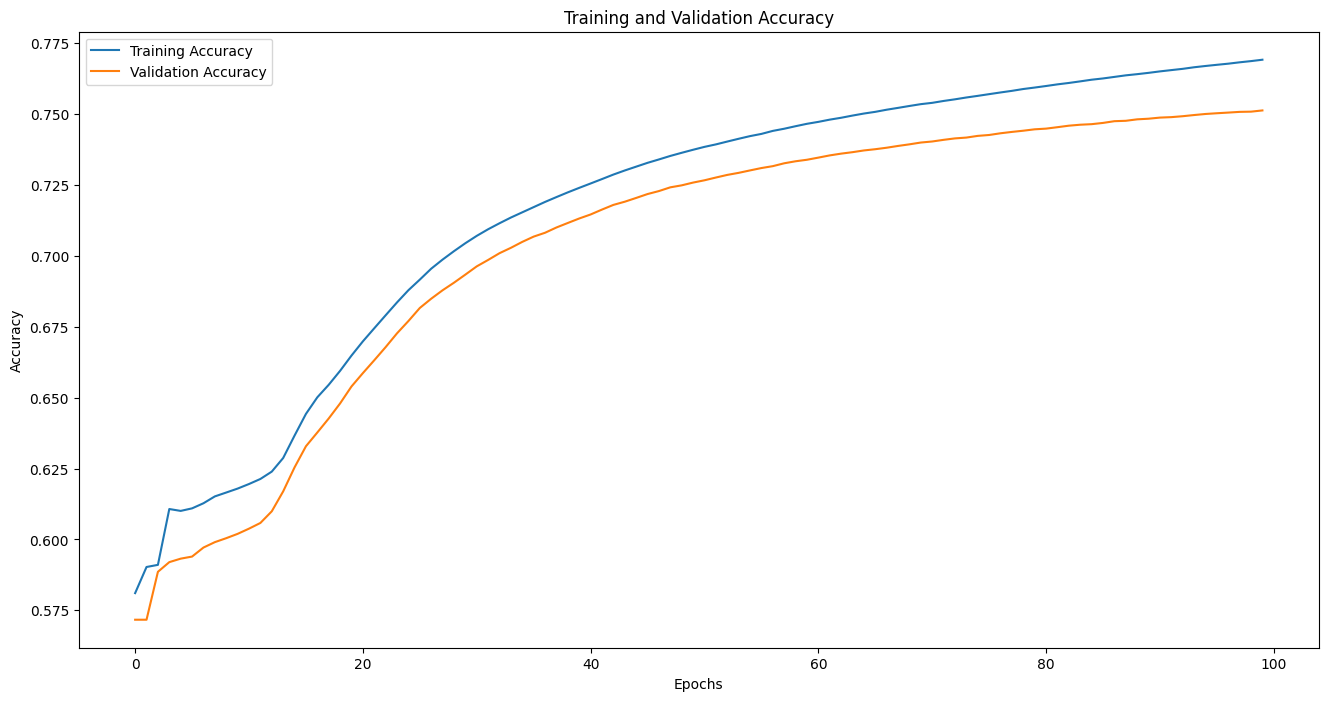

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss= history.history['loss']
val_loss= history.history['val_loss']

plt.figure(figsize=(16,8))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

## Plot of Loss vs Epochs

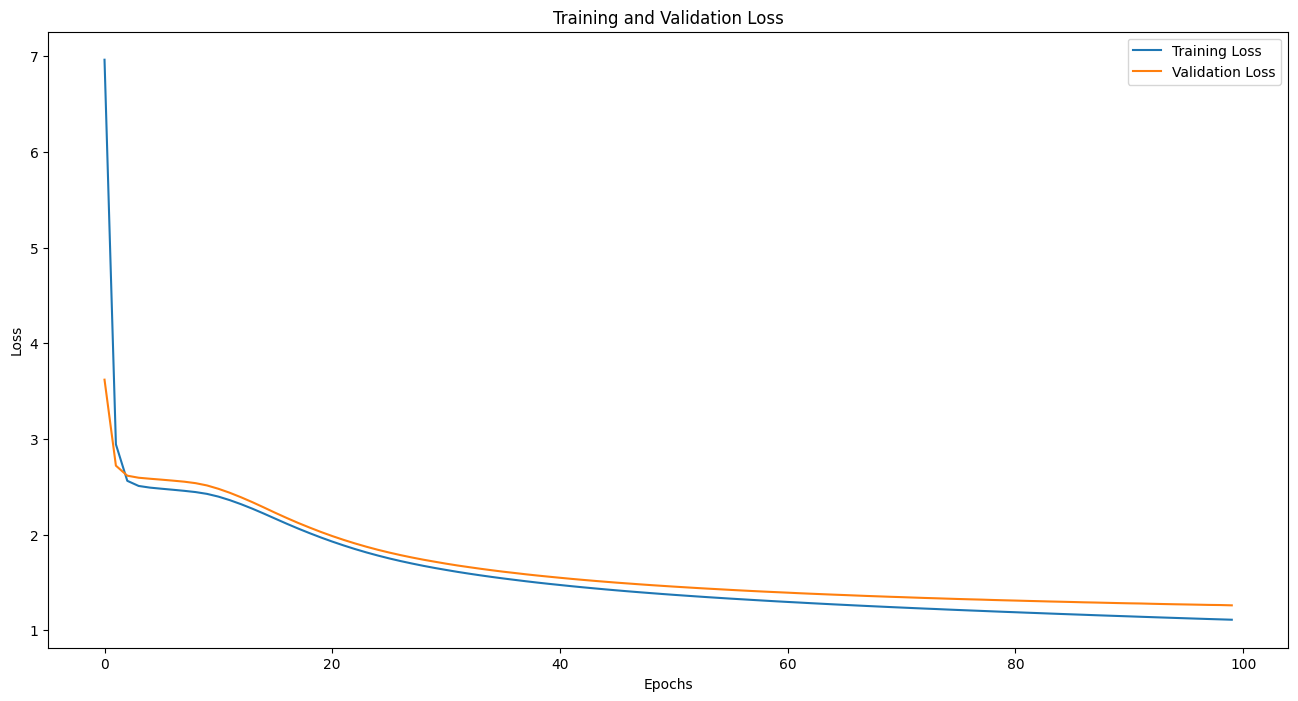

In [56]:
plt.figure(figsize=(16,8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Saving the trained models and downloading them

In [81]:
# Save the training model
model.save('training_model.h5')

# Save encoder model for inference
encoder_model.save('encoder_model.h5')

# Save decoder model for inference
decoder_model.save('decoder_model.h5')

# Download all three files
from google.colab import files
files.download('training_model.h5')
files.download('encoder_model.h5')
files.download('decoder_model.h5')

print("✅ All models saved and downloading!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ All models saved and downloading!


In [82]:
files.download('training_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Saving the Tokenizers used for training as pickle files

In [79]:
import pickle

# Save tokenizers
with open('encoder_tokenizer.pkl', 'wb') as f:
    pickle.dump(encoder_tokenizer, f)

with open('decoder_tokenizer.pkl', 'wb') as f:
    pickle.dump(decoder_tokenizer, f)

# Save other needed variables
config = {
    'max_encoder_seq_length': max_encoder_seq_length1,
    'max_decoder_seq_length': max_decoder_seq_length1,
    'num_encoder_tokens': num_encoder_tokens1,
    'num_decoder_tokens': num_decoder_tokens1
}

with open('config.pkl', 'wb') as f:
    pickle.dump(config, f)

# Download all
files.download('encoder_tokenizer.pkl')
files.download('decoder_tokenizer.pkl')
files.download('config.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Restricting the maximum length of response sentence for Inference Model

In [57]:
# Define a more reasonable maximum response length for inference
INFERENCE_MAX_RESPONSE_LENGTH = 50
print(f"Inference maximum response length set to: {INFERENCE_MAX_RESPONSE_LENGTH}")

Inference maximum response length set to: 50


# Encoder and Decoder Inference Models with the same LSTM Structure used during model training to maintain shape and parameter consistency

In [68]:
# ---------------- Encoder inference model ----------------
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# ---------------- Decoder inference model ----------------
# State inputs for inference
decoder_state_input_h = Input(shape=(dimensionality,), name="decoder_state_h")
decoder_state_input_c = Input(shape=(dimensionality,), name="decoder_state_c")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Encoder outputs input (needed for attention)
encoder_outputs_input = Input(shape=(None, dimensionality), name="encoder_outputs")

# New decoder input placeholder for inference
decoder_inputs_inference = Input(shape=(None,), name="decoder_inputs")

# Reuse trained embedding layer
decoder_embedding_layer = model.get_layer('decoder_embedding')
dec_emb_inference = decoder_embedding_layer(decoder_inputs_inference)

# Reuse trained LSTM layer
decoder_lstm_layer = model.get_layer('decoder_lstm')
decoder_outputs_inference, state_h_inference, state_c_inference = decoder_lstm_layer(
    dec_emb_inference, initial_state=decoder_states_inputs
)

# Reuse trained attention layer
attention_layer = model.get_layer('manual_attention_layer')
context_vector_inference = attention_layer([decoder_outputs_inference, encoder_outputs_input])

# Concatenate context with decoder outputs
decoder_concat_layer = Concatenate(axis=-1, name="decoder_concat_layer_inference")(
    [decoder_outputs_inference, context_vector_inference]
)

# Reuse trained dense layer
decoder_dense_layer = model.get_layer('decoder_dense')
decoder_outputs_final = decoder_dense_layer(decoder_concat_layer)

# Final decoder inference model
decoder_model = Model(
    [decoder_inputs_inference] + decoder_states_inputs + [encoder_outputs_input],
    [decoder_outputs_final, state_h_inference, state_c_inference]
)

print("Inference Models Created with Consistent Layer Naming")

Inference Models Created with Consistent Layer Naming


# Reverse Lookup Tables Created for bot response generation

In [67]:
# ---------------- Reverse Lookup Tables ----------------
target_token_index = decoder_tokenizer.word_index
reverse_target_index = {i: word for word, i in target_token_index.items()}

# Add PAD manually if needed
reverse_target_index[0] = "<PAD>"

print("Reverse Lookup Tables Created")
print("<start> ID:", target_token_index.get('<start>'))
print("<end> ID:", target_token_index.get('<end>'))

Reverse Lookup Tables Created
<start> ID: 34
<end> ID: 35


# Prediction Function created for generating responses during conversation

In [72]:
# ---------------- 11. Prediction Function ----------------
def decode_sequence(input_seq, repetition_penalty=1.5):
    # Encode input and retrieve encoder outputs and states
    encoder_output_seq, h, c = encoder_model.predict(input_seq)
    states_value = [h, c]

    # Start token
    start_token_id = target_token_index.get('<start>', 1)
    target_seq = np.array([[start_token_id]])

    decoded_sentence = ""
    stop_condition = False
    generated_tokens = []  # Track generated token IDs for repetition penalty

    while not stop_condition:
        # Decoder prediction step with attention
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value + [encoder_output_seq]
        )

        # Apply repetition penalty
        penalized_output_tokens = np.copy(output_tokens[0, -1, :])
        for token_id in generated_tokens:
            if token_id == 0:  # Skip padding
                continue
            penalized_output_tokens[token_id] /= repetition_penalty

        # Choose next token (greedy decoding)
        # Choose next token (top-k sampling instead of greedy)
        top_k = 5
        top_indices = penalized_output_tokens.argsort()[-top_k:]
        sampled_token_index = np.random.choice(top_indices)
        sampled_word = reverse_target_index.get(sampled_token_index, "<OOV>")

        # Append token index for penalty consistency
        generated_tokens.append(sampled_token_index)

        # Stop conditions
        if sampled_word == "<end>":
            stop_condition = True
        elif sampled_word not in ("<PAD>", "<OOV>", "<start>", "<end>"):
            decoded_sentence += " " + sampled_word

        # Fallback stop if too long
        if len(generated_tokens) >= INFERENCE_MAX_RESPONSE_LENGTH and not stop_condition:
            stop_condition = True

        # Update target_seq and states for next step
        target_seq = np.array([[sampled_token_index]])
        states_value = [h, c]

    # Final cleaning
    decoded_sentence = decoded_sentence.replace("<PAD>", "").replace("<OOV>", "").replace("<end>", "").replace("<start>", "").strip()

    return decoded_sentence


# Defining the class Chatbot

In [2]:
class ChatBot:
  negative_responses = ("no", "nope", "nah", "naw", "not a chance", "sorry", "not interested")
  exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop", "leave it")

  #Method to start the conversation
  def start_chat(self):
    user_response = input("Hi, I'm a chatbot trained on random dialogs!\n")

    if user_response.lower() in self.negative_responses:
      print("Ok, have a great day!")
      return
    self.chat(user_response)

  #Method to handle the conversation
  def chat(self, reply):
    while not self.make_exit(reply):
      reply = input(self.generate_response(reply)+"\n")

  #Method to convert user input into a matrix (tokenized and padded sequence)
  def string_to_matrix(self, user_input):
    # Tokenize the input sentence
    tokens = encoder_tokenizer.texts_to_sequences([user_input])
    # Pad the sequence to the maximum encoder sequence length used in training
    padded_tokens = pad_sequences(tokens, maxlen=max_encoder_seq_length1, padding='post')
    return padded_tokens

  #Method that will create a response using seq2seq model we built
  def generate_response(self, user_input):
    input_matrix = self.string_to_matrix(user_input)
    chatbot_response = decode_sequence(input_matrix)
    # Remove <start> and <end> tokens from chatbot_response (if they somehow remain)
    chatbot_response = chatbot_response.replace("<start>",'') # Use lowercase <start>
    chatbot_response = chatbot_response.replace("<end>",'')   # Use lowercase <end>
    chatbot_response = chatbot_response.replace("<OOV>",'')   # Remove <OOV> tokens
    chatbot_response = chatbot_response.replace("<PAD>",'')   # Remove <PAD> tokens
    return chatbot_response.strip() # Strip any leading/trailing spaces

  #Method to check for exit commands
  def make_exit(self, reply):
    for exit_command in self.exit_commands:
      if exit_command in reply.lower(): # Convert reply to lowercase for consistent checking
        print("Ok, have a great day!")
        return True
    return False

chatbot = ChatBot()

# Reassuring that Tokenizer is maintained throughout and not broken midway

In [75]:
print(decoder_tokenizer.word_index.get('<start>'))
print(decoder_tokenizer.word_index.get('<end>'))
print(decoder_tokenizer.word_index.get('<PAD>'))
print(decoder_tokenizer.word_index.get('<OOV>'))


34
35
None
1


In [76]:
for i in range(1, 10):  # first few IDs
    print(i, reverse_target_index.get(i))

1 <OOV>
2 and
3 .
4 to
5 your
6 the
7 a
8 of
9 you


# Testing with an example

In [65]:
# ---------------- 12. Chat Example ----------------
test_sentence = "hello how are you"
# Tokenize and pad the input sentence using the correct tokenizer and max length
test_seq = encoder_tokenizer.texts_to_sequences([test_sentence])
test_seq = pad_sequences(test_seq, maxlen=max_encoder_seq_length1, padding='post')

print("User:", test_sentence)
print("Bot:", chatbot.generate_response(test_sentence))

User: hello how are you
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6